In [123]:
#I made a module called spreader that takes the non numeric values and makes columns out of them and fills them with 1 
include("Spreader.jl")

Main.Spreader

In [124]:
# Julia has a richish ecosystem but being only twelve years old it's still evolvoiing
using CSV
using DataFrames
using RollingFunctions
using StatsBase
using ShiftedArrays
using PairPlots
using CairoMakie
using StatsPlots
using Chain
using Query
using .Spreader
using Colors
using ColorSchemes
using Plots
gr()

Plots.GRBackend()

In [125]:
# This was number was taken from a report titled "Labor Force and Occupation by Peter J Sepielli and Thomas K Palumbo from the graph on pg.39 (1994)
WORKERS = 123_082_000
print("Total Workers: $(WORKERS)")

Total Workers: 123082000

In [126]:
# Julia supports DataFrames like everyone else. Importing from CSV is not an official package.
df = DataFrame(CSV.File("Adult.csv", missingstring="?"))
println("Number of rows: $(string(nrow(df)))")

Number of rows: 48842


In [127]:
total_weight = sum(df[:,:fnlwgt])
print("Total weight: $(total_weight)" )

Total weight: 9263575662

In [128]:
weight_factor = WORKERS/total_weight
print("Weight factor: $(weight_factor)")

Weight factor: 0.013286662136834826

In [129]:
# This is where I use my magical spread function
spread!(df,"workclass")
spread!(df,"education")
spread!(df,"marital_status")
spread!(df,"occupation")
spread!(df,"race")
spread!(df,"sex")
spread!(df,"native_country")
spread!(df,"class")
println("Number of columns after spread operations: " * string(ncol(df)))

Number of columns after spread operations: 109


In [130]:

# The following lines multiply the new columns by fnlwgh and the calculated weight factor
df[!,Between(:Private,end)] = df[!,Between(:Private,end)] .* (df[!,:fnlwgt] * weight_factor)
df[!,Between(:Private,end)] = Int64.(round.(df[!,Between(:Private,end)]));

#This makes a total column that is actual total people
transform!(df, :fnlwgt => ((x) -> return 0) => :Total)
df[!,:Total] = df[!,:Total] = (df[!,:fnlwgt] * weight_factor)
df[!,:Total] = Int64.(round.(df[!,:Total]));

In [131]:
# Here I write the DataFrame out for the other programs to use
CSV.write("adult_spread.csv",df)

"adult_spread.csv"

In [132]:
# And here we create a grouped DataFrame
gdf = groupby(df,:sex)

# And then we sum over this group. Pretty neat
sex_private = combine(gdf, :Private => sum)

println("Grouped dataframe sumed for private employment")
print(sex_private)

Grouped dataframe sumed for private employment
2×2 DataFrame
 Row │ sex      Private_sum 
     │ String7  Int64       
─────┼──────────────────────
   1 │ Male        57927196
   2 │ Female      28869743

In [133]:
# Slightly differnet syntax using "do" syntax
gdf = groupby(df,[:education])
education_state_gov = combine(gdf) do sdf
    DataFrame(State_gov  = sum(sdf.State_gov))
end
println(" Grouped and summed DataFrame for education and state government enployment")
print(education_state_gov)

 Grouped and summed DataFrame for education and state government enployment
16×2 DataFrame
 Row │ education     State_gov 
     │ String15      Int64     
─────┼─────────────────────────
   1 │ 11th              39556
   2 │ HS-grad         1018610
   3 │ Assoc-acdm       155040
   4 │ Some-college    1218061
   5 │ 10th              51121
   6 │ Prof-school      127585
   7 │ 7th-8th           33257
   8 │ Bachelors       1025450
   9 │ Masters          569090
  10 │ Doctorate        297009
  11 │ 5th-6th           14984
  12 │ Assoc-voc        190707
  13 │ 9th               21159
  14 │ 12th              22804
  15 │ 1st-4th            3188
  16 │ Preschool          1031

In [134]:
# Ugh this took forever to figure out. The graphing library doesn't use the same kind of RGB types
cs1 = ColorScheme((reverse(Colors.sequential_palette(300, 100, logscale=true)))[1:5:80])
colors = [RGBA(cs1[i]) for i in 1:size(cs1)];

Proportion of Education Levels of Privatly Employed Individuals


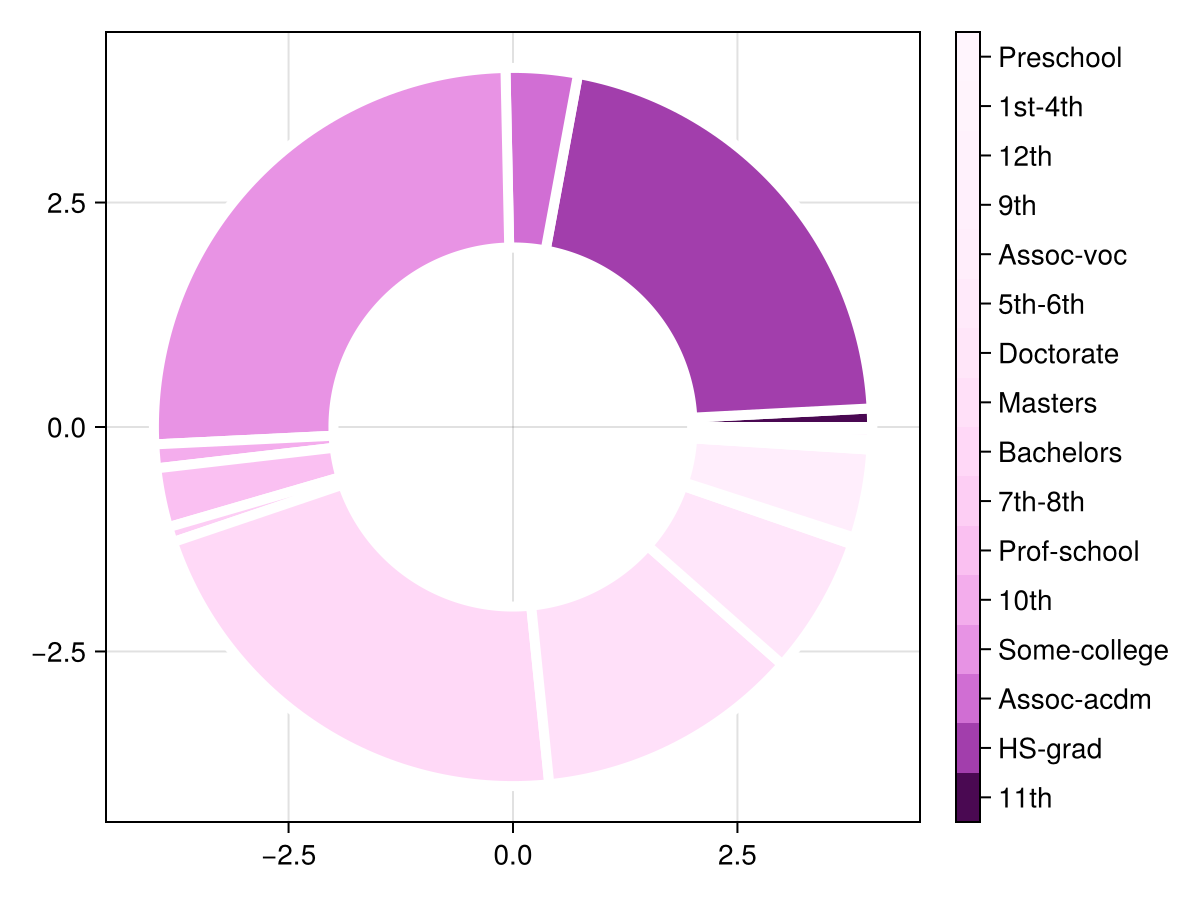

In [135]:
# Pie charts are the worst. Hard to label and hard to read but people love em
data = [education_state_gov[i,:State_gov] for i in 1:size(education_state_gov,1)]
category = [education_state_gov[i,:education] for i in 1:size(education_state_gov,1)]

nc = length(colors)
n = 1/nc

f, ax, plt = CairoMakie.pie(data,
                 radius = 4,
                 color = colors, 
                 inner_radius = 2,
                 strokecolor = :white,
                 strokewidth = 5,
                 axis = (autolimitaspect = 1, )
                )

cbar = Colorbar(f[1,2], colormap = cgrad(colors, categorical = true))
cbar.ticks = (range(0+n/2, 1-n/2, nc), string.(category))

println("Proportion of Education Levels of Privatly Employed Individuals")

Makie.save("Proportion of Education Levels of Privatly Employed Individuals (Julia).png", f)

f

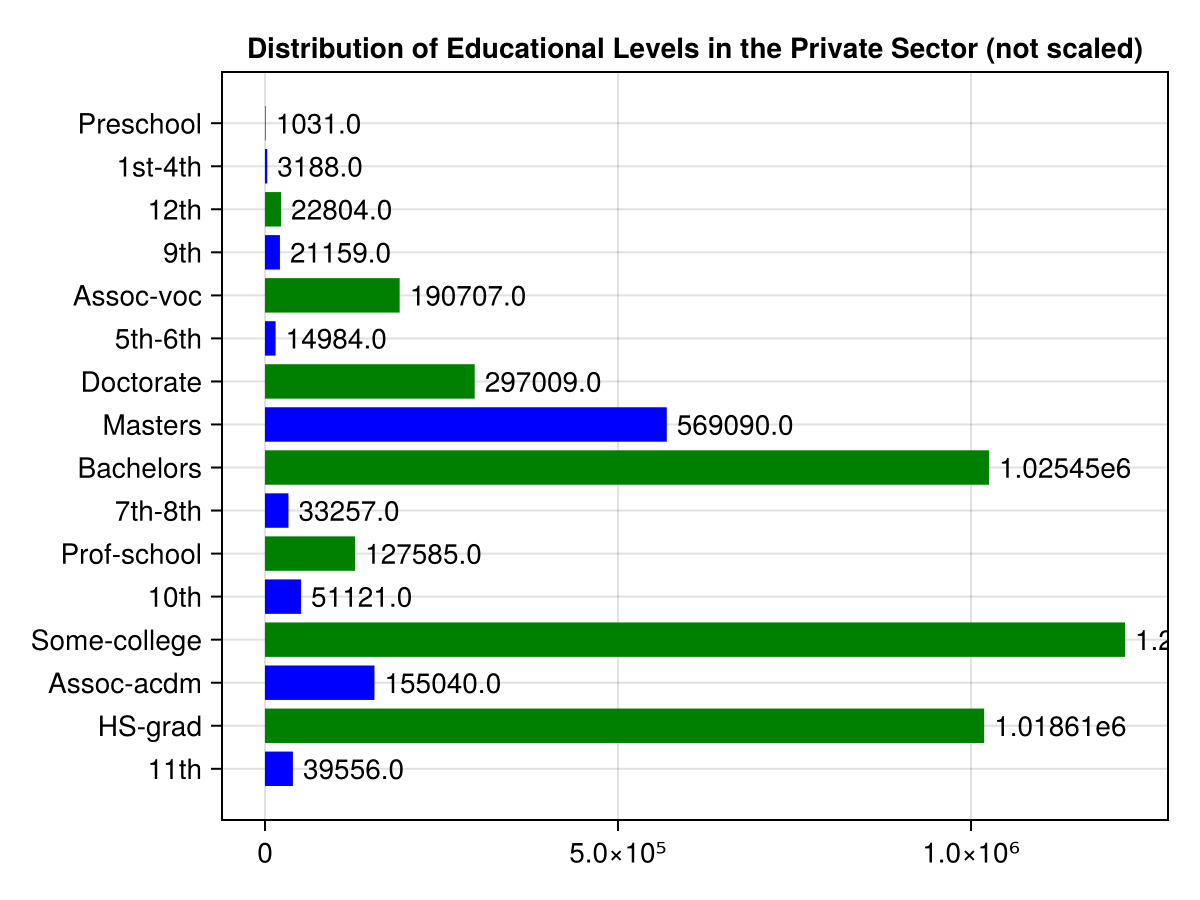

In [136]:
# I got this recspie from https://discourse.julialang.org/t/makie-version-of-a-simple-bar-graph-howto/72420/2
scene = barplot(1:length(data), data, 
	    direction=:x,
	    color=isodd.(1:length(data)),
	    colormap = [:green, :blue],
	    bar_labels=:y, 
	    axis = (yticks = (1:length(data), category),
                title = "Distribution of Educational Levels in the Private Sector (not scaled)"))

Makie.save("Distribution of Educational Levels in the Private Sector (not scaled) (Julia).png", scene)

scene

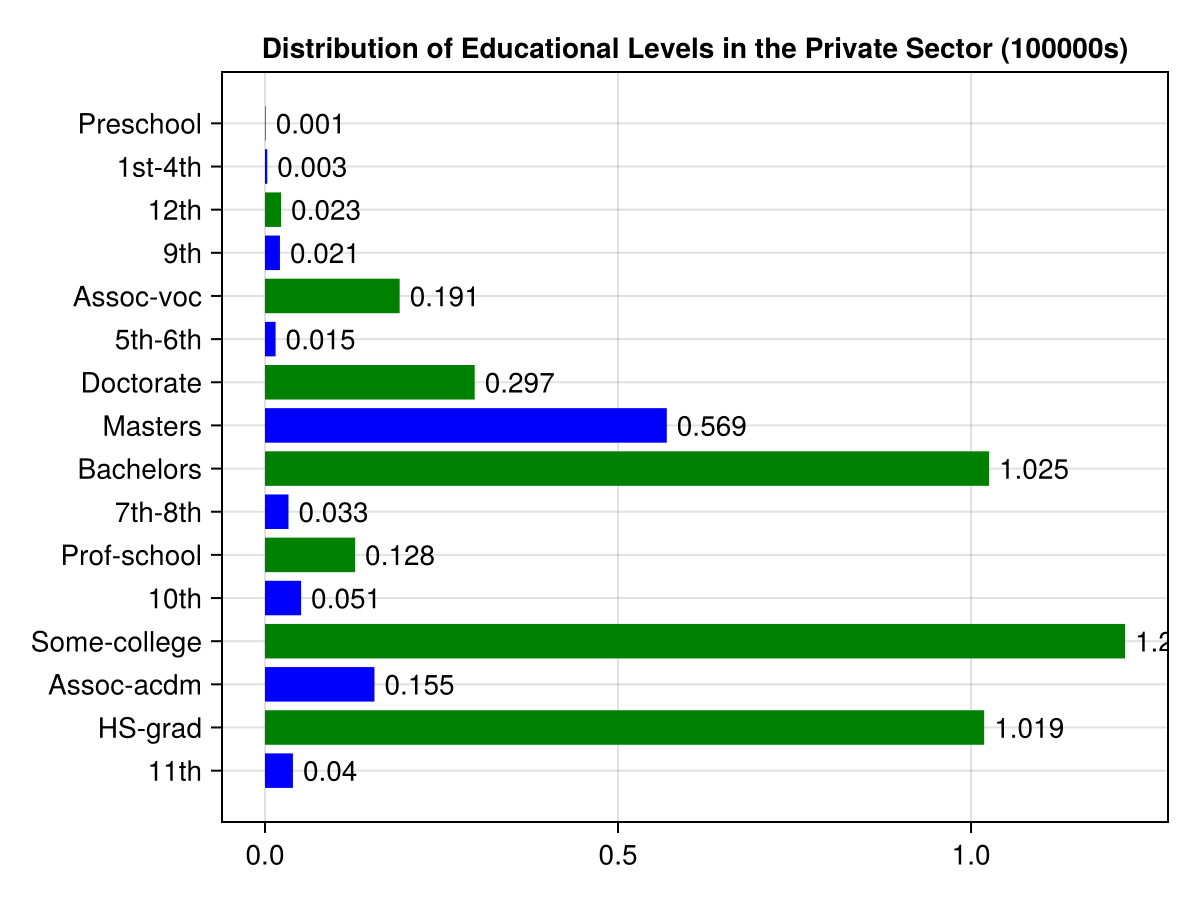

In [137]:
#But who wants to read exponents. It' sinple to multiply an entire vector.
scene = barplot(1:length(data), data * .000001, 
	    direction=:x,
	    color=isodd.(1:length(data)),
	    colormap = [:green, :blue],
	    bar_labels=:y, 
	    axis = (yticks = (1:length(data), category),
                title = "Distribution of Educational Levels in the Private Sector (100000s)"))

Makie.save("Distribution of Educational Levels in the Private Sector (scaled) (Julia).png", scene)

scene

In [138]:
# And here we create a grouped DataFrame
gdf = groupby(dropmissing(df),:occupation)

# And then we sum over this group. Pretty neat
totals_by_occupation = combine(gdf, :Total => sum)

println("Totals by Occupation")
print(totals_by_occupation)

# The convention in Julia is that if a function has side effects, it's name ends in a "!". Usually there is a non side effect version of every function that has side effects. Sort is no different.
sort!(totals_by_occupation, :occupation, rev=true)

Totals by Occupation
14×2 DataFrame
 Row │ occupation         Total_sum 
     │ String31           Int64     
─────┼──────────────────────────────
   1 │ Machine-op-inspct    7633340
   2 │ Farming-fishing      3385567
   3 │ Protective-serv      2615938
   4 │ Other-service       12002876
   5 │ Prof-specialty      14786892
   6 │ Craft-repair        15389153
   7 │ Adm-clerical        14118466
   8 │ Exec-managerial     14800470
   9 │ Tech-support         3578246
  10 │ Sales               13687480
  11 │ Priv-house-serv       596869
  12 │ Transport-moving     5886495
  13 │ Handlers-cleaners    5479388
  14 │ Armed-Forces           40709

Row,occupation,Total_sum
,String31,Int64
1,Transport-moving,5886495
2,Tech-support,3578246
3,Sales,13687480
4,Protective-serv,2615938
5,Prof-specialty,14786892
6,Priv-house-serv,596869
7,Other-service,12002876
8,Machine-op-inspct,7633340
9,Handlers-cleaners,5479388


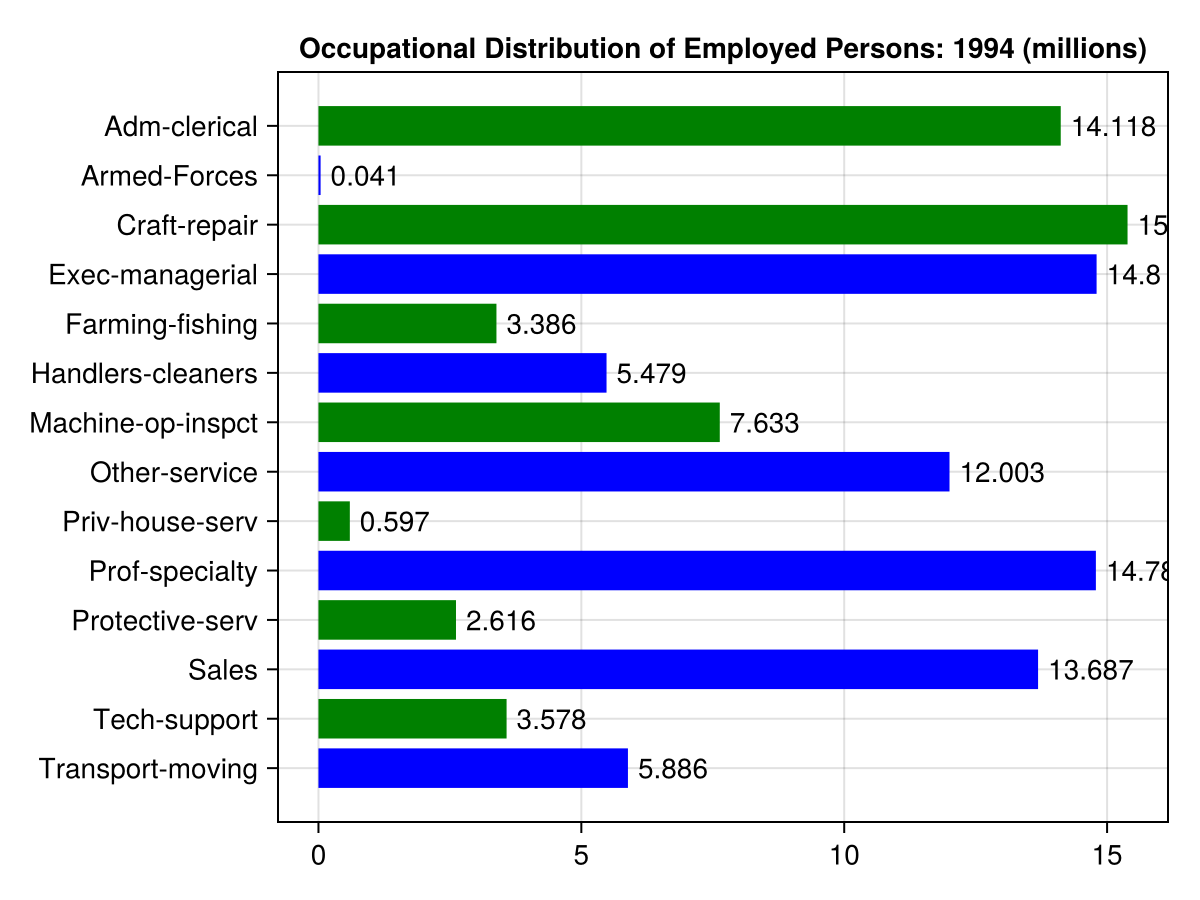

In [139]:
data = [totals_by_occupation[i,:Total_sum] for i in 1:size(totals_by_occupation,1)]
category = [totals_by_occupation[i,:occupation] for i in 1:size(totals_by_occupation,1)]

scene = barplot(1:length(data), data * .000001, 
	    direction=:x,
	    color=isodd.(1:length(data)),
	    colormap = [:green, :blue],
	    bar_labels=:y, 
	    axis = (yticks = (1:length(data), category),
                title = "Occupational Distribution of Employed Persons: 1994 (millions)"))

Makie.save("Occupational Distribution of Employed Persons (millions) (Julia).png", scene)

scene